## Process data

In [29]:
import json
import re


train_file = 'train_456-fixedIds.json'
dev_file = 'dev_83-fixedIds.json'


def split_sentence(_text):
    sentences = _text.split('<br>')
#     print(sentences)
#     print(len(sentences))
#     raise RuntimeError()
    output = []
    for index, sentence in enumerate(sentences):
        if sentence == '':
            continue
        # <b>Sent {sentence_id}: </b>: text
        g = sentence.split('</b>')
        title = g[0]
        text = g[1]
        assert len(g) == 2
        sentence_id = int(title[8:-2])
        assert sentence_id - 1 == index, (sentence_id, index)
        output.append(text)
    return output

def pre_process(file):
    data = json.load(open(file, 'r'))['data']
    
    output = []
    for v in data:
        data_id = v['id']
        text = v['paragraph']['text']
        _questions = v['paragraph']['questions']
        
        article = split_sentence(text)
        evidence_list = []
        questions = []
        options_list = []
        answers = []
        multisent_list = []
        
        for _q in _questions:
            questions.append(_q['question'])
            evidence_list.append(_q['sentences_used'])
            options_list.append([_a['text'] for _a in _q['answers']])
            answers.append([1 if _a['isAnswer'] else 0 for _a in _q['answers']])
            multisent_list.append(_q['multisent'])
            
            for _evidence in _q['sentences_used']:
                assert _evidence < len(article)
        
        output.append({
            'article': article,
            'id': data_id,
            'questions': questions,
            'options': options_list,
            'answers': answers,
            'evidences': evidence_list,
            'multi_sents': multisent_list
        })
    return output

train = pre_process(train_file)
dev = pre_process(dev_file)

print(len(train))
print(len(dev))

456
83


In [30]:
with open('train.json', 'w') as f:
    json.dump(train, f, indent=2)
with open('dev.json', 'w') as f:
    json.dump(dev, f, indent=2)

## Data Statistics for MultiRC

In [25]:
from pytorch_pretrained_bert.tokenization import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained('/home/jiaofangkai/bert-base-uncased-vocab.txt')

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import Counter

def write_plot_piece_num(_data):
    token_num_list = []
    for instance in tqdm(_data, total=len(_data)):
        article = instance['article']
        questions = instance['questions']
        answers = instance['answers']
        choices = instance['options']
        article_token_num = len(bert_tokenizer.tokenize(" ".join(article)))
        for question, choice_list in zip(questions, choices):
            question_token_num = len(bert_tokenizer.tokenize(question))
            for choice in choice_list:
                option_token_num = len(bert_tokenizer.tokenize(choice))
                token_num_list.append(article_token_num + question_token_num + option_token_num)
                
    token_num_cnt = Counter(token_num_list)
    xy = sorted(token_num_cnt.items(), key=lambda x: x[0], reverse=False)
    x = [a[0] for a in xy]
    y = [a[1] for a in xy]
    plt.plot(x, y)
    plt.show()
    
def write_plot_sentence_num(_data):
    sentence_num = []
    for instance in tqdm(_data, total=len(_data)):
        sentence_num.append(len(instance['article']))
    
    sentence_num_cnt = Counter(sentence_num)
    xy = sorted(sentence_num_cnt.items(), key=lambda x: x[0], reverse=False)
    x = [a[0] for a in xy]
    y = [a[1] for a in xy]
    plt.plot(x, y)
    plt.show()

100%|██████████| 456/456 [00:05<00:00, 81.07it/s]


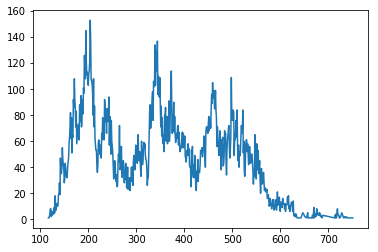

In [26]:
write_plot_piece_num(train)

100%|██████████| 83/83 [00:01<00:00, 59.69it/s]


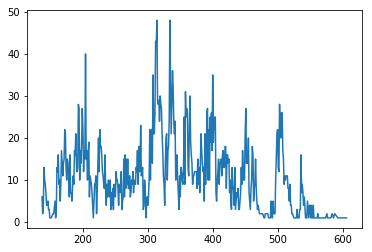

In [27]:
write_plot_piece_num(dev)

100%|██████████| 456/456 [00:00<00:00, 408413.97it/s]


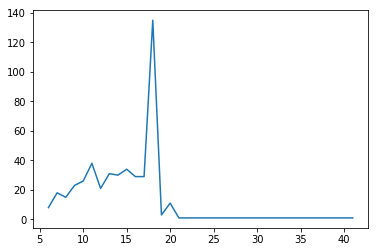

100%|██████████| 83/83 [00:00<00:00, 231621.58it/s]


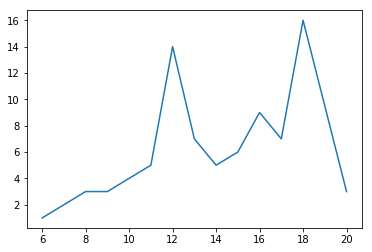

In [28]:
write_plot_sentence_num(train)
write_plot_sentence_num(dev)

In [32]:
ques = dev[0]['questions'][-2]
print(bert_tokenizer.tokenize(ques))

['what', 'kind', 'of', 'career', 'does', 'christie', 'brink', '##ley', 'have', '?']


In [33]:
ques = dev[0]['questions'][-1]
print(bert_tokenizer.tokenize(ques))

['how', 'many', 'male', 'models', 'were', 'featured', 'in', 'the', 'current', 'video']
